# 6 Regression Discontinuity

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

np.random.seed(12282020)

## 6.2.2 Continuity

In [2]:
# rdd_simulate1

In [3]:
n = 1000
df = pd.DataFrame(index = range(n))
random_draws = np.random.normal(50, 25, n)
df['x'] = (random_draws > 0) * random_draws
df = df[df.x < 100]

df['D'] = 1 * (df.x > 50)

df['y1'] = 25 + 0*df.D + 1.5 * df.x + np.random.normal(0, 20, len(df))
df['y2'] = 25 + 40*df.D + 1.5 * df.x + np.random.normal(0, 20, len(df))

In [4]:
def helper(D, ax, col = 'y1'):
    global df
    
    temp = df[df.D == D]
    marker = 'o'
    color = 'lightgray'
    
    if D > 0:
        marker = '^'
        color = 'black'
    ax.scatter(temp.x, temp[col],
               color=color,
               alpha=0.95,
               marker=marker,
               edgecolor='black',
               s=12)
    del temp
    
def reg_helper(D, col = 'y1'):
    global df
    temp = df[df.D == D]
    y = temp[col]
    X = sm.add_constant(temp['x'])
    model = sm.OLS(y, X).fit()
    return model.params

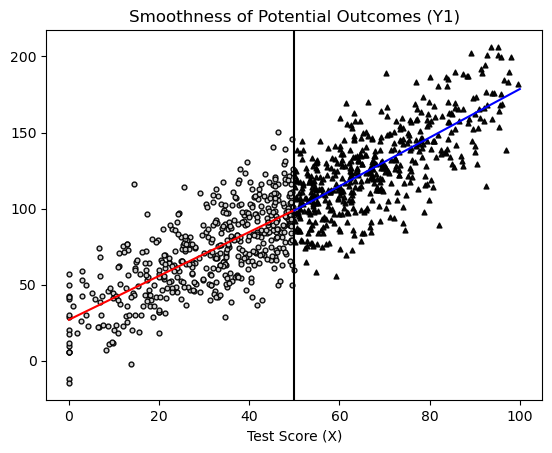

In [5]:
fig, ax = plt.subplots()
helper(0,ax)
helper(1,ax)
ax.axvline(50, ymin = 0, ymax = 1, color = 'black' )

ax.set_title("Smoothness of Potential Outcomes (Y1)")
ax.set_xlabel("Test Score (X)")

params = reg_helper(D = 0)
y = np.linspace(np.dot(np.array([1,0]),params), np.dot(np.array([1,50]),params),2)
ax.plot(np.linspace(0,50,2), y, color = 'red')

params = reg_helper(D = 1)
y = np.linspace(np.dot(np.array([1,50]),params), np.dot(np.array([1,100]),params),2)
ax.plot(np.linspace(50,100,2), y, color = 'blue')

plt.show()

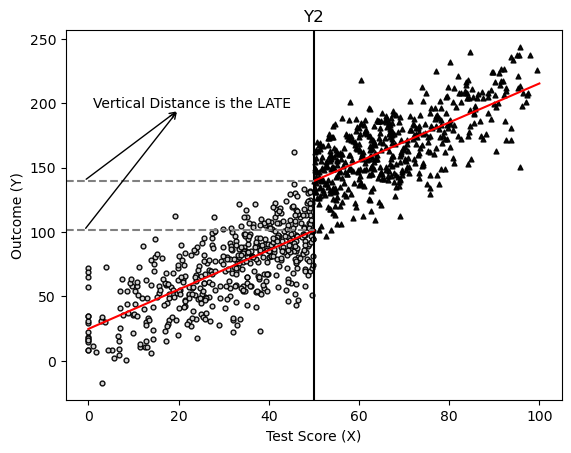

In [6]:
fig, ax = plt.subplots()
helper(0,ax, col = 'y2')
helper(1,ax, col = 'y2')
ax.axvline(50, ymin = 0, ymax = 1, color = 'black' )

ax.set_title("Smoothness of Potential Outcomes (Y1)")
ax.set_xlabel("Test Score (X)")

params = reg_helper(D = 0, col = 'y2')
y = np.linspace(np.dot(np.array([1,0]),params), np.dot(np.array([1,50]),params),2)
y1 = y[1]
ax.plot(np.linspace(0,50,2), y, color = 'red')

params = reg_helper(D = 1, col = 'y2')
y = np.linspace(np.dot(np.array([1,50]),params), np.dot(np.array([1,100]),params),2)
y2 = y[0]
ax.plot(np.linspace(50,100,2), y, color = 'red')

# Annotations
hline_style = dict(linestyle='dashed',color='gray')
ax.axhline(y2, 0, .5, **hline_style)
ax.axhline(y1, 0, .5, **hline_style)

ax.text(23, 200, s = 'Vertical Distance is the LATE', ha = 'center', va = 'center')
arrow_props = dict(facecolor='gray', arrowstyle = '<-')
ax.annotate('', xy=(-1, y1), xytext=(20, 195),
            arrowprops=arrow_props)
ax.annotate('', xy=(-1, y2), xytext=(20, 195),
            arrowprops=arrow_props)

ax.set_ylabel('Outcome (Y)')
ax.set_xlabel("Test Score (X)")
ax.set_title("Y2")
plt.show()

## 6.2.3 Estimation using local and global least squares

In [7]:
# rdd_simulate3
np.random.seed(12282020)

obs = 1000
x = np.random.normal(100, 50, obs)

df = pd.DataFrame({'const':np.ones(obs)})

df['x'] = np.maximum(0,x)  # running variable
df['x2'], df['x3'] = df.x**2, df.x**3  # polynomial terms
df['D'] = 1*(df.x > 140)  # treatment 

# Outcome variable - no effect from D, but nonlinear f(x)
df['y'] = 10000 + 0*df.D - 100*df.x + df.x2 + np.random.normal(0,1000,obs)

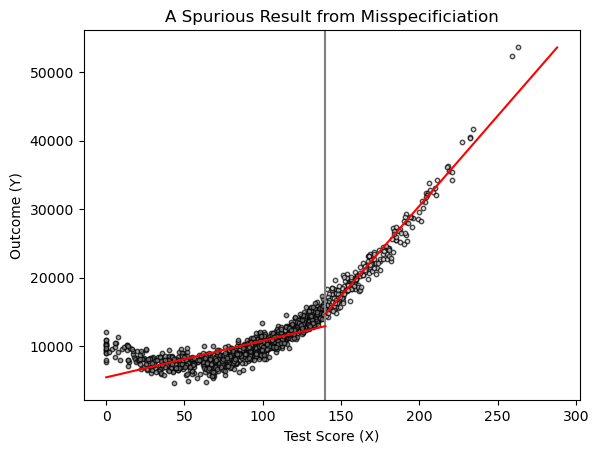

In [8]:
# Make plot with vertical line at cutoff c_0
c0 = 140
plt.axvline(c0, color = 'gray')

# Make scatter plot
scatter_style = dict(edgecolor = 'black', s = 10, alpha = 0.7)

# Above c_0
top = df[df.x > c0]
plt.scatter(top.x, top.y,
            facecolor='lightgray',
            **scatter_style)

# Below c_0
bottom = df[df.x <= c0]
plt.scatter(bottom.x, bottom.y, 
            facecolor='gray',
            **scatter_style)

# Plot Regression Lines
paramsD1 = sm.OLS(top.y, top[['x','const']]).fit().params
x_ = np.linspace(c0, 288, 2)
plt.plot(x_, paramsD1['const'] + x_*paramsD1['x'], color = 'red')

paramsD0 = sm.OLS(bottom.y, bottom[['x','const']]).fit().params
x_ = np.linspace(0, c0, 2)
plt.plot(x_, paramsD0['const'] + x_*paramsD0['x'], color = 'red')


plt.xlabel("Test Score (X)")
plt.ylabel("Outcome (Y)")
plt.title("A Spurious Result from Misspecificiation")
plt.show()

In [9]:
reg = sm.OLS(df['y'], df[['D','const','x']]).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     2201.
Date:                Tue, 27 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:28:38   Log-Likelihood:                -9318.0
No. Observations:                1000   AIC:                         1.864e+04
Df Residuals:                     997   BIC:                         1.866e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D           6109.7445    302.135     20.222      0.0

In [10]:
# LATE is the gap in predictions
late = paramsD1.values @ np.array([c0,1]) - paramsD0.values @ np.array([c0,1])
print("LATE", late, sep=': ')

LATE: 1769.8389070611956


### Higher-Order Polynomials

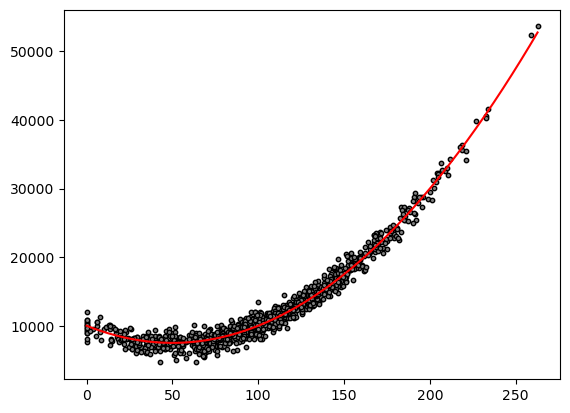

In [11]:
# rdd_simulated4

# overwrite y from before
#df['y'] = 10000 + 0*df.D - 100*df.x + df.x2 + np.random.normal(0,1000,obs)

plt.scatter(df.x, df.y, color = 'gray', edgecolor = 'black', s = 10)
x_ = np.linspace(0,df.x.max(),301)
plt.plot(x_, -100*x_ + x_**2 + 10000, color = 'red')
plt.show()

In [12]:
# interactions
for power in range(1,4):
    df['Dx'+str(power)] = df['D'] * df['x']**power

reg_all = sm.OLS(df.y, df[['const','D','x', 'x2','x3', 'Dx1','Dx2','Dx3']]).fit()
reg_quad = sm.OLS(df.y, df[['const','D','x', 'x2']]).fit()

In [13]:
print(reg_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 1.312e+04
Date:                Tue, 27 Feb 2024   Prob (F-statistic):               0.00
Time:                        00:28:38   Log-Likelihood:                -8311.7
No. Observations:                1000   AIC:                         1.663e+04
Df Residuals:                     996   BIC:                         1.665e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9757.7082    114.385     85.306      0.0

## 6.2.4 Nonparametric kernels

In [14]:
#lmb_1

df = pd.read_stata("https://github.com/scunning1975/mixtape/raw/master/lmb-data.dta")
lmb_subset = df.query('0.48 < lagdemvoteshare < 0.52')

y1 = df['score']

fit_args = dict(cov_type="cluster",cov_kwds={"groups":lmb_subset['id']})
lm_1 = sm.OLS(lmb_subset['score'], sm.add_constant(lmb_subset.lagdemocrat))\
                .fit(**fit_args)
lm_2 = sm.OLS(lmb_subset['score'], sm.add_constant(lmb_subset.democrat))\
                .fit(**fit_args)
lm_3 = sm.OLS(lmb_subset['democrat'], sm.add_constant(lmb_subset.lagdemocrat))\
                .fit(**fit_args)

stargazer = Stargazer([lm_1, lm_2, lm_3])
stargazer